In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import math
from sklearn.preprocessing import StandardScaler 

In [16]:
# input the stock ticker we wana study
stock_ticker = "TSLA"
current_date = '2025-03-28'
maturity_date = '2025-04-17'
option_type = 'call' 

In [17]:
# read option chain file
df = pd.read_excel('Combined_' + stock_ticker + '_options_15-Apr-25.xlsx')

In [18]:
# Function to get option chain in the dataframe
# Select option chain with specific current date and maturity date
def get_option_chain(df_input, symbol_input, direction, current_date_input, maturity_date_input=None):
    # Ignore maturity date when the user doesn't put in a maturity date
    condition = (df_input["Symbol"] == symbol_input) & (df_input['Direction'] == direction) & (df_input['Current Date'] == current_date_input)
    # Filter with maturity date when the user put in a maturity date
    if not maturity_date_input is None:
        condition = condition & (df_input['Expiration Date'] == maturity_date_input)
    df_res = df_input[condition]
    return df_res

# Function to perform linear regression with list of columns as input, using sm.OLS
def linear_regression(df_input, y_col, x_cols):
    df = df_input
    X = df[x_cols]
    y = df[y_col]
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    model = sm.OLS(y, X).fit()
    return model

# Define a function to plot the IVM across moneyness with maturity in the legend
def plot_ivm_across_moneyness(df_input, symbol_input, direction_input, current_date_input):

    # Filter the data for the specified stock, direction, and date
    df_target = get_option_chain(df_input, symbol_input, direction_input, current_date_input)
    
    # Group by maturity (time_to_maturity_years)
    grouped = df_target.groupby('time_to_maturity_years')
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    for maturity, group in grouped:
        plt.scatter(group['moneyness'], group['IVM'], label=f'Maturity: {maturity:.2f} years')
    
    # Add labels, title, legend, and grid
    plt.xlabel('Moneyness')
    plt.ylabel('IVM')
    plt.title(f'IVM across Moneyness for {symbol_input} {direction_input} options on {current_date_input}')
    plt.legend(title='Maturity (years)', loc='best')
    plt.grid()
    plt.show()

# Function to plot 3D graph of IVM across moneyness and time_to_maturity_years
def plot_ivm_across_moneyness_and_days(df, symbol_input, direction, current_date_input):

    # Get the filtered option chain
    df_target = get_option_chain(df, symbol_input, direction, current_date_input)
    
    # Create the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df_target['moneyness'], 
               df_target['time_to_maturity_years'], 
               df_target['IVM'], 
               color='blue')
    
    # Set labels and title
    ax.set_xlabel('Moneyness')
    ax.set_ylabel('Time to Maturity (in years)')
    ax.set_zlabel('IVM')
    ax.set_title(f'IVM across Moneyness and Time to Maturity for {symbol_input} {direction} options on {current_date_input}')
    
    # Show the plot
    plt.show()

# Function to input current stock price, strike, maturity date and direction, then output moneyess, time_to_maturity_years,'moneyness_squared', 'maturity_squared', 'moneyness_maturity' in list
def get_warrant_moneyness_expiration(current_stock_price, strike, maturity_date_input, current_date_input):
    # Convert dates to datetime format
    current_date = pd.to_datetime(current_date_input)
    maturity_date = pd.to_datetime(maturity_date_input)
    
    # Calculate moneyness and time_to_maturity_years
    moneyness = current_stock_price / strike
    time_to_expiration_days = (maturity_date - current_date).days
    time_to_expiration_years = time_to_expiration_days / 365
    
    # Calculate squares and products
    moneyness_squared = moneyness ** 2
    maturity_squared = time_to_expiration_years ** 2
    moneyness_maturity = moneyness * time_to_expiration_years
    
    return [moneyness, time_to_expiration_years, moneyness_squared, maturity_squared, moneyness_maturity]


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11199 entries, 0 to 11198
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Ticker                    11199 non-null  object 
 1   Symbol                    11199 non-null  object 
 2   Expiration Date           11199 non-null  object 
 3   Strike                    11199 non-null  float64
 4   Bid                       11199 non-null  float64
 5   Ask                       11199 non-null  float64
 6   Last                      11199 non-null  float64
 7   IVM                       11199 non-null  float64
 8   Direction                 11199 non-null  object 
 9   Current Date              11199 non-null  object 
 10  Current Date Stock Price  11199 non-null  float64
dtypes: float64(6), object(5)
memory usage: 962.5+ KB


In [20]:
#show unique values in "Expiration Date" in ascending order
date_count = df["Expiration Date"].value_counts().reset_index()
date_count["Expiration Date"] = pd.to_datetime(date_count["Expiration Date"])
date_count.set_index("Expiration Date", inplace=True)
date_count = date_count.sort_index()
date_count

,count
Expiration Date,
2025-01-17,880
2025-02-21,2720
2025-03-21,3359
2025-04-17,2880
2025-04-25,160
2025-05-16,1200


In [21]:
# Remove rows where "IVM" is 0
df = df[df['IVM'] != 0]
df.head()

,Ticker,Symbol,Expiration Date,Strike,Bid,Ask,Last,IVM,Direction,Current Date,Current Date Stock Price
1,TSLA 4/17/25 P207.5,TSLA,17-Apr-2025,207.5,0.120000,0.140000,0.12,105.147621,put,15-Apr-2025,254.110001
2,TSLA 4/17/25 P262.5,TSLA,17-Apr-2025,262.5,11.400000,11.600000,10.70,62.645725,put,15-Apr-2025,254.110001
3,TSLA 4/17/25 P265,TSLA,17-Apr-2025,265.0,13.350000,13.600000,12.48,63.222397,put,15-Apr-2025,254.110001
4,TSLA 4/17/25 P267.5,TSLA,17-Apr-2025,267.5,15.450000,15.700000,14.60,64.077888,put,15-Apr-2025,254.110001
5,TSLA 4/17/25 P270,TSLA,17-Apr-2025,270.0,17.550003,17.899994,16.75,64.198608,put,15-Apr-2025,254.110001


In [ ]:
# Add columns for regression

# Ensure 'Expiration Date' and 'Current Date' are in datetime format
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])
df['Current Date'] = pd.to_datetime(df['Current Date'])

# Add moneyness, time to maturity in days and time to maturity in years
df['moneyness'] = df['Current Date Stock Price'] / df['Strike']
df['time_to_maturity_days'] = (df['Expiration Date'] - df['Current Date']).dt.days
df['time_to_maturity_years'] = df['time_to_maturity_days'] / 365

# Standardize moneyness, time_to_maturity_days and time_to_maturity_years
scaler = StandardScaler()
cols_to_standardize = ['moneyness', 'time_to_maturity_days', "time_to_maturity_years"]
df[cols_to_standardize] = scaler.fit_transform(df[cols_to_standardize])

# Add a column 'moneyness square'
df['moneyness_squared'] = df['moneyness'] ** 2

# Add a column 'maturity_squared'
df['maturity_squared'] = df['time_to_maturity_years'] ** 2

df['moneyness_maturity']= df['moneyness'] * df['time_to_maturity_years']

df['log_IVM'] = np.log(df['IVM'])

col_order = ['Ticker', 'Symbol', 'Current Date', 'Expiration Date', 'time_to_maturity_days', 'time_to_maturity_years', 'Current Date Stock Price', 'Strike', 'Bid', 'Ask', 'Last',
       'IVM', 'Direction', 'moneyness', 'moneyness_squared', 'maturity_squared', 'moneyness_maturity', 'log_IVM']
df = df.loc[:, col_order]

df.head()

1     1.008273
2    -0.267850
3    -0.313270
4    -0.357840
5    -0.401586
6    -0.444528
7    -0.486690
9    -0.568755
13   -0.724395
14   -0.761642
Name: moneyness, dtype: float64


In [23]:
# Select the option chain for a specific stock, direction, and current date and maturity date
df_target = get_option_chain(df, stock_ticker, option_type, current_date, maturity_date)

# Define the dependent and independent variables
dependent_var = 'log_IVM'  # USE log IVM
independent_vars = ['moneyness', 'time_to_maturity_years', 'moneyness_squared', 'maturity_squared', 'moneyness_maturity'] # we set the regressor

# Perform linear regression
regression_summary = linear_regression(df_target, dependent_var, independent_vars).summary()

# Display the regression summary
print(regression_summary)

KeyError: "['time_to_maturity_years', 'moneyness_squared', 'maturity_squared', 'moneyness_maturity'] not in index"

In [ ]:
# print(df_new[['IVM']])

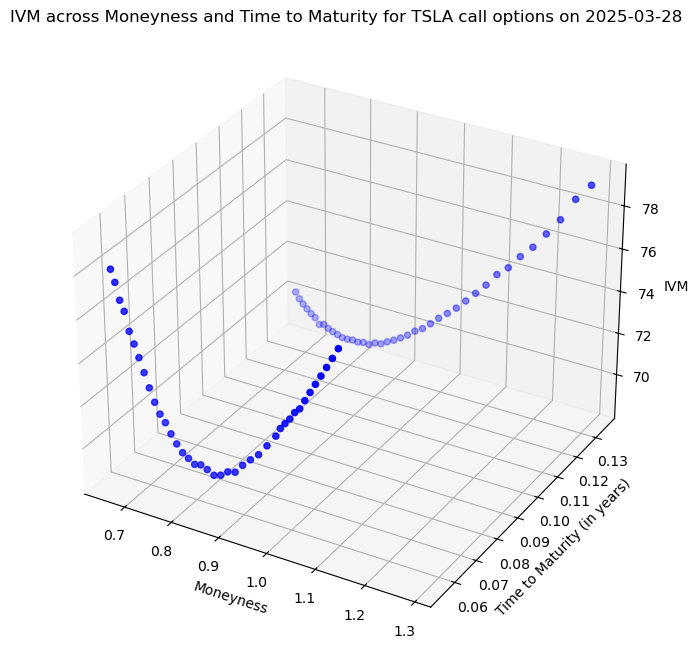

In [ ]:
plot_ivm_across_moneyness_and_days(df, stock_ticker, 'call', current_date)  #show call volatility smile

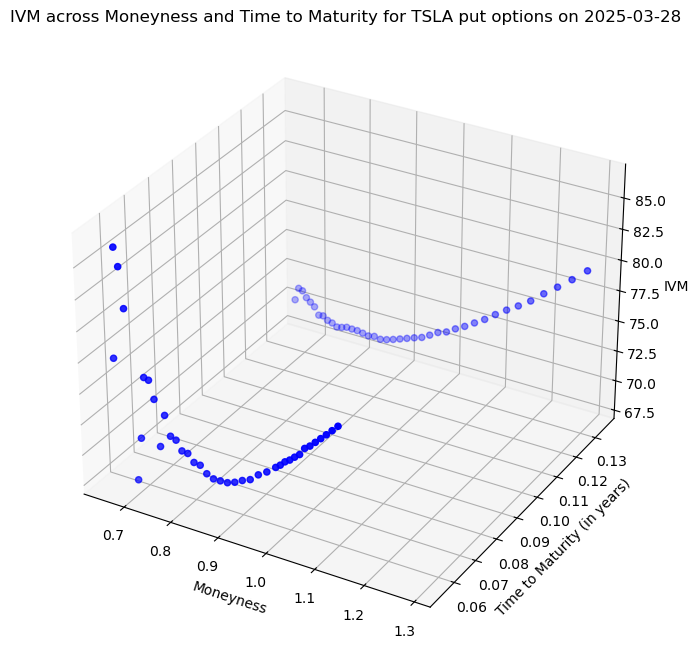

In [ ]:
plot_ivm_across_moneyness_and_days(df, stock_ticker, 'put', current_date)  # show put volatility smile

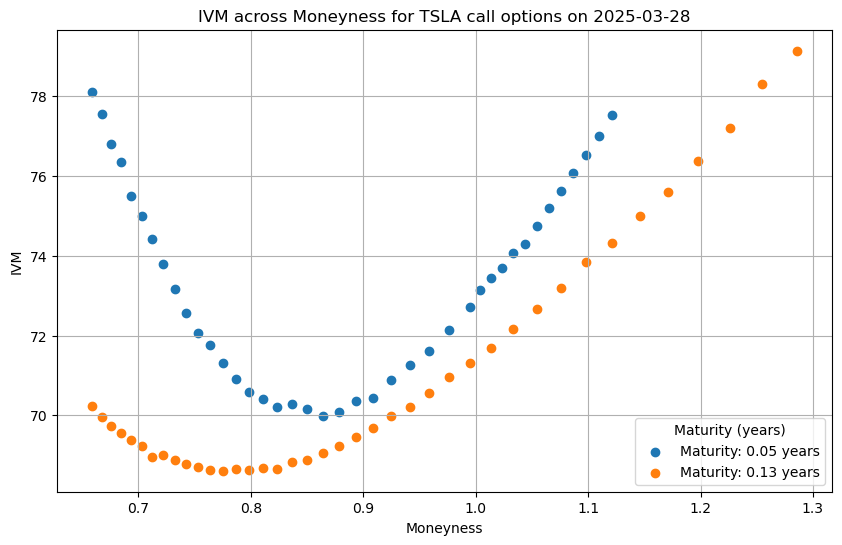

In [ ]:
plot_ivm_across_moneyness(df, stock_ticker, 'call', '2025-03-28')  # show call volatility smileb

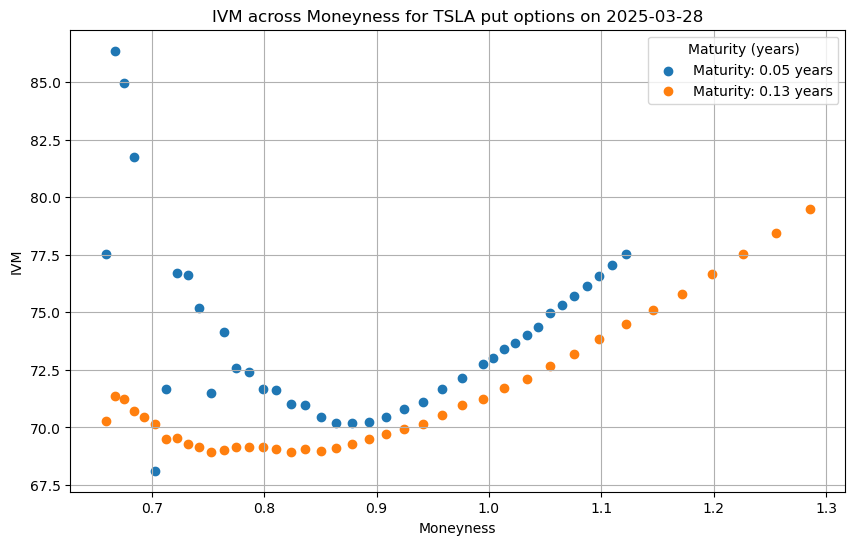

In [ ]:
plot_ivm_across_moneyness(df, stock_ticker, 'put', '2025-03-28')  # show put volatility smile

We test with the following regression models, letting $K$ be moneyness, $T$ be time to maturity, $K*T$ be moneyness_maturity, $K^2$ be moneyness squared and $T^2$ be maturity squared.

- Model 1: $K, T, K*T$
- Model 2: $K, T, K^2$
- Model 3: $K, T, T^2$
- Model 4: $K, T, K^2, K*T$
- Model 5: $K, T, T^2, K*T$
- Model 6: $K, T, K^2, T^2, K*T$

In [ ]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model1: K,T,K*T

independent_vars_one = ['moneyness', 'time_to_maturity_years', 'moneyness_maturity'] # model1: K,T,K*T
model = linear_regression(df_target, dependent_var, independent_vars_one)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_IVM   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.3750
Date:                Fri, 18 Apr 2025   Prob (F-statistic):              0.544
Time:                        16:49:14   Log-Likelihood:                 79.010
No. Observations:                  40   AIC:                            -154.0
Df Residuals:                      38   BIC:                            -150.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
moneyness                  0

In [ ]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model2: K,T,K^2

independent_vars_two = ['moneyness', 'time_to_maturity_years', 'moneyness_squared'] # model2: K,T,K^2
model = linear_regression(df_target, dependent_var, independent_vars_two)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_IVM   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     447.2
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           1.21e-26
Time:                        16:49:14   Log-Likelihood:                 143.33
No. Observations:                  40   AIC:                            -280.7
Df Residuals:                      37   BIC:                            -275.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
moneyness                 -3

In [ ]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model3: K,T,T^2

independent_vars_three = ['moneyness', 'time_to_maturity_years', 'maturity_squared'] # model3: K,T,T^2
model = linear_regression(df_target, dependent_var, independent_vars_three)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_IVM   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.3750
Date:                Fri, 18 Apr 2025   Prob (F-statistic):              0.544
Time:                        16:49:14   Log-Likelihood:                 79.010
No. Observations:                  40   AIC:                            -154.0
Df Residuals:                      38   BIC:                            -150.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
moneyness                  0

In [ ]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model4: K,T,K^2,K*T

independent_vars_four = ['moneyness', 'time_to_maturity_years', 'moneyness_squared', 'moneyness_maturity'] # model4: K,T,K^2,K*T
model = linear_regression(df_target, dependent_var, independent_vars_four)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_IVM   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     447.2
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           1.21e-26
Time:                        16:49:14   Log-Likelihood:                 143.33
No. Observations:                  40   AIC:                            -280.7
Df Residuals:                      37   BIC:                            -275.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
moneyness                 -3

In [ ]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model5 K,T,T^2,K*T

independent_vars_five = ['moneyness', 'time_to_maturity_years','maturity_squared','moneyness_maturity'] # model5 K,T,T^2,K*T
model = linear_regression(df_target, dependent_var, independent_vars_five)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_IVM   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.3750
Date:                Fri, 18 Apr 2025   Prob (F-statistic):              0.544
Time:                        16:49:14   Log-Likelihood:                 79.010
No. Observations:                  40   AIC:                            -154.0
Df Residuals:                      38   BIC:                            -150.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
moneyness                  0

In [ ]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model6:K,T,K^2,T^2,K*T

independent_vars_six = ['moneyness', 'time_to_maturity_years', 'moneyness_squared', 'maturity_squared','moneyness_maturity'] # model6:K,T,K^2,T^2,K*T
model = linear_regression(df_target, dependent_var, independent_vars_six)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_IVM   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     447.2
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           1.21e-26
Time:                        16:49:14   Log-Likelihood:                 143.33
No. Observations:                  40   AIC:                            -280.7
Df Residuals:                      37   BIC:                            -275.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
moneyness                 -3

In [ ]:
# Function to perform linear regression with list of columns as input, using sm.OLS
#prototype regression model

independent_vars = ['moneyness', 'time_to_maturity_years', 'moneyness_squared', 'maturity_squared', 'moneyness_maturity']
model = linear_regression(df_target, dependent_var, independent_vars)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_IVM   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     447.2
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           1.21e-26
Time:                        16:49:14   Log-Likelihood:                 143.33
No. Observations:                  40   AIC:                            -280.7
Df Residuals:                      37   BIC:                            -275.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
moneyness                 -3

In [ ]:
# output warrant moneyness, time_to_maturity_years, 'moneyness_squared', 'maturity_squared', 'moneyness_maturity' in list
#******INPUT warrant data HERE ******
current_stock_price = 277.13
strike = 350
maturity_date = '2025-05-21'
current_date = '2025-03-27'
warrant_moneyness_expiration = get_warrant_moneyness_expiration(current_stock_price, strike, maturity_date, current_date)
print(warrant_moneyness_expiration)

[0.7918, 0.1506849315068493, 0.6269472399999999, 0.022705948583223865, 0.11931232876712328]


In [ ]:
# apply the regression model to calcualte warrant IVM
X_new = pd.DataFrame([warrant_moneyness_expiration], columns=independent_vars)
predictions = model.predict(X_new)
print(predictions)


0    14.450712
dtype: float64


In [ ]:
# prediction of in sample data, IVM from bloomberg and IVM predicted from the regression 

# df_target['Predicted_IVM'] = math.exp(model.predict(df_target[independent_vars]))

df_target['Predicted_IVM'] = np.exp(model.predict(df_target[independent_vars]))
print(df_target[['IVM', 'Predicted_IVM']])

            IVM  Predicted_IVM
1840  77.520314      78.713147
1842  78.106521      77.449489
1843  70.146310      70.406265
1844  70.269279      70.547882
1845  70.203729      70.733626
1846  70.395128      70.959611
1847  70.580363      71.222361
1848  70.908242      71.518756
1849  71.301744      71.845987
1850  71.750361      72.201520
1851  72.075324      72.583058
1852  72.557190      72.988522
1853  73.158720      73.416016
1854  73.794622      73.863813
1855  74.424280      74.330336
1856  74.988073      74.814140
1857  75.507840      75.313898
1858  76.362989      75.828393
1859  76.809985      76.356500
1860  70.083094      70.273386
1861  70.344727      70.292561
1862  70.438793      70.376934
1863  74.307925      74.015696
1865  77.010853      77.861736
1866  76.532706      77.077901
1867  76.075479      76.356749
1868  75.630683      75.693832
1869  75.191419      75.085098
1870  74.752041      74.526846
1871  74.068314      73.548550
1872  70.877141      70.533643
1873  73

/var/folders/w0/hns05fls5vdbgj18ty4hk9w00000gp/T/ipykernel_17095/3407225289.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['Predicted_IVM'] = np.exp(model.predict(df_target[independent_vars]))


In [ ]:
# Extract only the date part from 'Current Date' and 'Expiration Date'
current_dates = [date.strftime('%Y-%m-%d') for date in df['Current Date'].dt.date.unique()]
maturity_dates = [date.strftime('%Y-%m-%d') for date in df['Expiration Date'].dt.date.unique()]

# Print the results
print(current_dates)
print(maturity_dates)



['2025-04-15', '2025-04-14', '2025-04-11', '2025-04-10', '2025-04-09', '2025-04-08', '2025-04-07', '2025-04-04', '2025-04-03', '2025-04-02', '2025-04-01', '2025-03-28', '2025-03-27', '2025-03-26', '2025-03-25', '2025-03-24', '2025-03-21', '2025-03-20', '2025-03-19', '2025-03-18', '2025-03-17', '2025-03-14', '2025-03-13', '2025-03-12', '2025-03-11', '2025-03-10', '2025-03-07', '2025-03-06', '2025-03-05', '2025-03-04', '2025-03-03', '2025-02-28', '2025-02-27', '2025-02-26', '2025-02-25', '2025-02-24', '2025-02-21', '2025-02-20', '2025-02-19', '2025-02-18', '2025-02-14', '2025-02-13', '2025-02-12', '2025-02-11', '2025-02-10', '2025-02-07', '2025-02-06', '2025-02-05', '2025-02-04', '2025-02-03', '2025-01-31', '2025-01-30', '2025-01-29', '2025-01-28', '2025-01-27', '2025-01-24', '2025-01-23', '2025-01-22', '2025-01-21', '2025-01-17', '2025-01-16', '2025-01-15', '2025-01-14', '2025-01-13', '2025-01-10', '2025-01-08', '2025-01-07', '2025-01-06', '2025-01-03', '2025-01-02']
['2025-04-17', '202

In [ ]:
independent_vars_one = ['moneyness', 'time_to_maturity_years', 'moneyness_maturity'] # model1: K,T,K*T
independent_vars_two = ['moneyness', 'time_to_maturity_years', 'moneyness_squared'] # model2: K,T,K^2
independent_vars_three = ['moneyness', 'time_to_maturity_years', 'maturity_squared'] # model3: K,T,T^2
independent_vars_four = ['moneyness', 'time_to_maturity_years','moneyness_squared','moneyness_maturity'] # model4: K,T,K^2,K*T
independent_vars_five = ['moneyness', 'time_to_maturity_years','maturity_squared','moneyness_maturity'] # model5 K,T,T^2,K*T
independent_vars_six = ['moneyness', 'time_to_maturity_years','moneyness_squared','maturity_squared','moneyness_maturity'] # model6:K,T,K^2,T^2,K*T

ress = [] # store the regression result in a list, current_date, maturity_date, model1, model2, model3, model4, model5, model6

for current_date in current_dates:
    res = []
    for maturity_date in maturity_dates:
        df_target = get_option_chain(df, stock_ticker, 'call', current_date, maturity_date)
        if df_target.empty:
            continue
        dependent_var = 'IVM'
        model1 = linear_regression(df_target, dependent_var, independent_vars_one)
        model2 = linear_regression(df_target, dependent_var, independent_vars_two)
        model3 = linear_regression(df_target, dependent_var, independent_vars_three)
        model4 = linear_regression(df_target, dependent_var, independent_vars_four)
        model5 = linear_regression(df_target, dependent_var, independent_vars_five)
        model6 = linear_regression(df_target, dependent_var, independent_vars_six)

        res.append([current_date, maturity_date,
                    model1.rsquared_adj,
                    model2.rsquared_adj,
                    model3.rsquared_adj,
                    model4.rsquared_adj,
                    model5.rsquared_adj,
                    model6.rsquared_adj])
    ress.append(res)

In [ ]:
# Flatten the nested list `ress`
flattened_ress = [item for sublist in ress for item in sublist]

# Create a DataFrame
columns = ['Current Date', 'Maturity Date', 'Model1 adj_R-squared', 'Model2 adj_R-squared', 
           'Model3 adj_R-squared', 'Model4 adj_R-squared', 'Model5 adj_R-squared', 'Model6 adj_R-squared']
df_regression_results_adj_rsquare = pd.DataFrame(flattened_ress, columns=columns)

# Display the DataFrame
print(df_regression_results_adj_rsquare)
df_regression_results_adj_rsquare.to_excel(stock_ticker+'_log_regression_results_adj_rsquare.xlsx', index=False)

    Current Date Maturity Date  Model1 adj_R-squared  Model2 adj_R-squared  \
0     2025-04-15    2025-04-17             -0.031238              0.708975   
1     2025-04-15    2025-04-25              0.739007              0.776240   
2     2025-04-14    2025-04-17              0.623286              0.868053   
3     2025-04-14    2025-04-25              0.923558              0.931495   
4     2025-04-11    2025-04-17              0.829481              0.968566   
..           ...           ...                   ...                   ...   
135   2025-01-06    2025-01-17              0.901678              0.977031   
136   2025-01-03    2025-02-21              0.516577              0.892668   
137   2025-01-03    2025-01-17              0.833148              0.874362   
138   2025-01-02    2025-02-21              0.061458              0.843233   
139   2025-01-02    2025-01-17              0.065796              0.888380   

     Model3 adj_R-squared  Model4 adj_R-squared  Model5 adj_R-s